This code reads the GeneratedParticles branch of the tree provided by a neutral current reaction simulation.

First, we import the requisite ROOT libraries.

In [1]:
import ROOT
from ROOT import TFile, TTree, TLorentzVector, TH1F, TH2F, TCanvas, TPad, TGraph
from array import array

Welcome to JupyROOT 6.28/00


Now, we can access the root file containing the simulation and get the `events` tree saved within.

Then, we create a pointer to the PDG leaf, which contains the Monte Carlo particle numbers of each particle, as well as some dictionaries that map each number to the corresponding particle name. We also create a dictionary that stores the amount of each particle.

In [2]:
filename = 'pythia8NCDIS_10x100_minQ2=100_beamEffects_xAngle=-0.025_hiDiv_vtxfix_1_000.0002.eicrecon.tree.edm4eic.root'
file = TFile(filename)

tree = file.Get('events')

Warning in <TClass::Init>: no dictionary for class podio::GenericParameters is available
Warning in <TClass::Init>: no dictionary for class pair<int,podio::GenericParameters> is available
Warning in <TClass::Init>: no dictionary for class podio::CollectionIDTable is available
Warning in <TClass::Init>: no dictionary for class podio::version::Version is available
Warning in <TClass::Init>: no dictionary for class edm4hep::MCParticleData is available
Warning in <TClass::Init>: no dictionary for class edm4hep::Vector3d is available
Warning in <TClass::Init>: no dictionary for class edm4hep::Vector3f is available
Warning in <TClass::Init>: no dictionary for class edm4hep::Vector2i is available
Warning in <TClass::Init>: no dictionary for class podio::ObjectID is available
Warning in <TClass::Init>: no dictionary for class edm4eic::ClusterData is available
Warning in <TClass::Init>: no dictionary for class edm4eic::Cov3f is available
Warning in <TClass::Init>: no dictionary for class edm4ei

In [3]:
pdg = tree.GetLeaf('GeneratedParticles.PDG')

particles_def = {11: 'electron',
                 22: 'gamma particle',
                 130: 'KL-neutral meson',
                 211: 'pi+ meson',
                 321: 'K+ meson',
                 2112: 'neutron',
                 2212: 'proton'}
particles_count = {'electron': 0,
                   'gamma particle': 0,
                   'pi+ meson': 0,
                   'KL-neutral meson': 0,
                   'K+ meson': 0,
                   'neutron': 0,
                   'proton': 0,
                   'other': 0}

This logic will iterate through the tree and then each entry in the leaf. Through this iteration, we can find the number of each particle in the simulation. In the case that we encounter a particle not listed in the `particles_def` dictionary, we add one to the `other` entry in the count dictionary.

In [4]:
for ev in tree:
    for i in range(pdg.GetLen()):
        key = abs(int(pdg.GetValue(i)))
        if key in particles_def.keys():
            particles_count[particles_def[key]] += 1
        else:
            particles_count['other'] += 1

for key, value in particles_count.items():
    print(f'Number of {key}s: {value}')

13
14
13
14
13
14
13
14
13
13
13
13
13
13
14
13
12
13
14
12
13
14
12
13
12
12
16
16
13
1000010030
12
12
13
14
13
14
1000010020
16
16
12
13
1000010020
13
14
13
14
16
16
13
13
13
14
12
12
12
13
1000010020
12
1000010020
13
14
12
13
14
12
12
13
14
13
14
1000010020
12
12
12
12
1000010020
13
13
13
12
12
13
1000010020
Number of electrons: 2633
Number of gamma particles: 19403
Number of pi+ mesons: 15968
Number of KL-neutral mesons: 765
Number of K+ mesons: 1617
Number of neutrons: 1868
Number of protons: 2174
Number of others: 83


We can now plot these values in a bar chart by using the frequency of each particle. To do this, we use the `numpy` and `matplotlib` libraries.

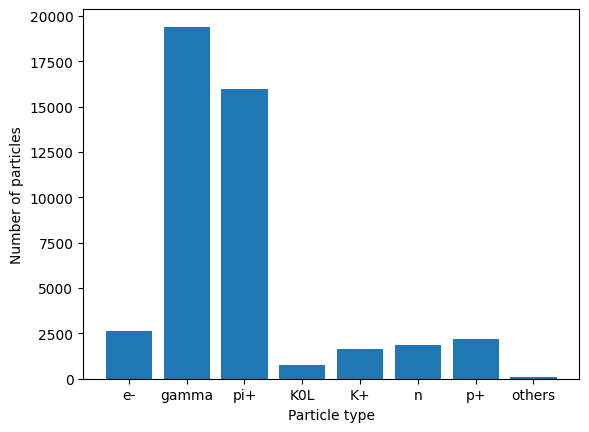

In [5]:
import numpy as np
import matplotlib.pyplot as plt

labels = ['e-', 'gamma', 'pi+', 'K0L', 'K+', 'n', 'p+', 'others']
x = np.arange(len(labels))
width = 0.8

fig, ax = plt.subplots()
bar = ax.bar(x, particles_count.values(), width)

ax.set_ylabel('Number of particles')
ax.set_xlabel('Particle type')
ax.set_xticks(x, labels)

plt.show()

In [6]:
def get_log_bins(nbins, xmin, xmax):
    xbins = []
    base = np.exp((np.log(xmax) - np.log(xmin)) / nbins)
    
    for i in range(nbins):
        xbins.append(xmin * np.power(base, i))
    xbins.append(xmax)
    
    return array('d', xbins)

In [7]:
m_e = 0.000511 # GeV
m_pi = 0.139570 # GeV
m_k = 0.493677 # GeV
m_p = 0.93827 # GeV
m_mu = 0.105658 # GeV

Ee = 10 # GeV
Ep = 100 # GeV

px = tree.GetLeaf('GeneratedParticles.momentum.x')
py = tree.GetLeaf('GeneratedParticles.momentum.y')
pz = tree.GetLeaf('GeneratedParticles.momentum.z')
E = tree.GetLeaf('GeneratedParticles.energy') # ? might assume pion mass

four_p = TLorentzVector()

# Electron value histograms
e_ptot_hist = TH1F('e_ptot', 'Total Momentum for Electrons Histogram', 100, 0, 30)
e_pt_hist = TH1F('e_pt', 'Transverse Momentum for Electrons Histogram', 100, 0, 30)
e_theta_hist = TH1F('e_theta', 'Theta for Electrons Histogram', 30, 0, 180)
e_eta_hist = TH1F('e_eta', 'Eta for Electrons Histogram', 20, -5, 5)

# Electron value graphs (change into 2 dimensional histograms)
e_ptot_theta = TH2F('e_ptot_theta', 'Theta vs. Total momentum for Electrons', 20, 0, 180, 20, 0, 30)
e_ptot_eta = TH2F('e_ptot_eta', 'Eta vs. Total momentum for Electrons', 20, -5, 5, 20, 0, 30)
e_pt_eta = TH2F('e_pt_eta', 'Eta vs. Transverse momentum for Electrons', 20, -5, 5, 20, 0, 30)

# Kinematics reconstruction (electron method)
e_x_hist = TH1F('e_x', 'x for Electrons', 20, get_log_bins(20, 1e-3, 1))
e_Q2_hist = TH1F('e_Q2', 'Q^2 for Electrons', 20, get_log_bins(20, 10, 4 * Ee * Ep))
e_dx_hist = TH1F('e_dx', 'Uncertainty in x for Electrons', 20, get_log_bins(20, 1e-3, 1))
e_dQ2_hist = TH1F('e_dQ2', 'Uncertainity in Q^2 for Electrons', 20, get_log_bins(20, 1, 200))
e_x_Q2 = TH2F('e_x_Q2', 'x vs. Q^2 for Electrons', 20, get_log_bins(20, 1e-3, 1), 20, get_log_bins(20, 10, 4 * Ee * Ep))
e_x_dx = TH2F('e_x_dx', 'x vs. Uncertainity in x for Electrons', 20, get_log_bins(20, 1e-3, 1), 20, get_log_bins(20, 1e-3, 1))
e_Q2_dQ2 = TH2F('e_Q2_dQ2', 'Q^2 vs. Uncertainity in Q^2 for Electrons', 20, get_log_bins(20, 10, 4 * Ee * Ep), 20, get_log_bins(20, 1, 200))

# Kinematics reconstruction (Jacquet-Blondel method)
jb_x_hist = TH1F('jb_x_hist', 'x for Other Particles Histogram', 20, get_log_bins(20, 1e-3, 1))
jb_Q2_hist = TH1F('jb_Q2_hist', 'Q^2 for Other Particles Histogram', 20, get_log_bins(20, 10, 4 * Ee * Ep))
jb_x_Q2 = TH2F('jb_x_Q2', 'x vs Q^2 for Other Particles', 20, get_log_bins(20, 1e-3, 1), 20, get_log_bins(20, 10, 4 * Ee * Ep))

# Reconstruction comparisons
e_jb_x = TH2F('e_jb_x', 'Electron method vs. Jacquet-Blondel method for reconstruction of x', 20, get_log_bins(20, 1e-3, 1), 20, get_log_bins(20, 1e-3, 1))
e_jb_Q2 = TH2F('e_jb_Q2', 'Electron method vs. Jacquet-Blondel method for reconstruction of Q^2', 20, get_log_bins(20, 10, 4 * Ee * Ep), 20, get_log_bins(20, 10, 4 * Ee * Ep))

In [8]:
for ev in tree:
    Epzh = 0
    pxh = 0
    pyh = 0
    
    for i in range(px.GetLen()):
        four_p.SetXYZM(px.GetValue(i),
                       py.GetValue(i),
                       pz.GetValue(i),
                       m_e)
        if abs(int(pdg.GetValue(i))) == 11 and E.GetValue(i) > 0.1:
            e_ptot_hist.Fill(four_p.Rho())
            e_pt_hist.Fill(four_p.Pt())
            
            theta = 3.1415926535 - four_p.Theta()
            theta_deg = theta * 180 / 3.14159265
            e_theta_hist.Fill(theta_deg) # Plot 180 - theta (in degrees)
            
            # eta = -np.log(np.tan(theta / 2))
            e_eta_hist.Fill(four_p.Eta())
            
            e_ptot_theta.Fill(theta_deg, four_p.Rho())
            e_ptot_eta.Fill(four_p.Eta(), four_p.Rho())
            e_pt_eta.Fill(four_p.Eta(), four_p.Pt())
            
            Q2 = 2 * Ee * E.GetValue(i) * (1 - np.cos(theta))
            s = 4 * Ee * Ep
            y = 1 - (E.GetValue(i) / Ee) * ((np.cos(theta / 2)) ** 2)
            x = Q2 / (s * y)
            
            dE_E = 0.15
            dtheta = 5e-4
            dQ2 = Q2 * (dE_E - np.tan(theta / 2) * dtheta)
            dx = x * (dE_E / y + np.tan(theta / 2) * (x * (Ep / Ee)) - 1 * dtheta)
            
            # Clamping the y
            if y >= 0.01 and y <= 0.95:
                e_x_hist.Fill(x)
                e_Q2_hist.Fill(Q2)
                e_dx_hist.Fill(dx)
                e_dQ2_hist.Fill(dQ2)
                
                e_x_Q2.Fill(x, Q2)
                e_x_dx.Fill(x, dx)
                e_Q2_dQ2.Fill(Q2, dQ2)
                
                e_x = x
                e_Q2 = Q2
    
    # Apply clamp for pseudorapidity for all remnants of proton
    # Plot E-pz, energies, total momenta and other values
    # Plot difference between JB and electron methods using
    #   histograms as function of x and Q^2
        four_p.SetPxPyPzE(px.GetValue(i),
                          py.GetValue(i),
                          pz.GetValue(i),
                          E.GetValue(i))
        
        clamp = four_p.Eta() > -4 and four_p.Eta() < 4
        
        if abs(int(pdg.GetValue(i))) != 11 and clamp:
            Epzh += E.GetValue(i) - pz.GetValue(i)
            pxh += px.GetValue(i)
            pyh += py.GetValue(i)
    
    pth2 = np.power(pxh, 2) + np.power(pyh, 2)
    
    y = Epzh / (2 * Ee)
    Q2 = pth2 / (1 - y)
    s = 4 * Ee * Ep
    x = Q2 / (s * y)
            
    jb_x_hist.Fill(x)
    jb_Q2_hist.Fill(Q2)
    jb_x_Q2.Fill(x, Q2)
    
    if e_x and e_Q2:
        e_jb_x.Fill(e_x, x)
        e_jb_Q2.Fill(e_Q2, Q2)

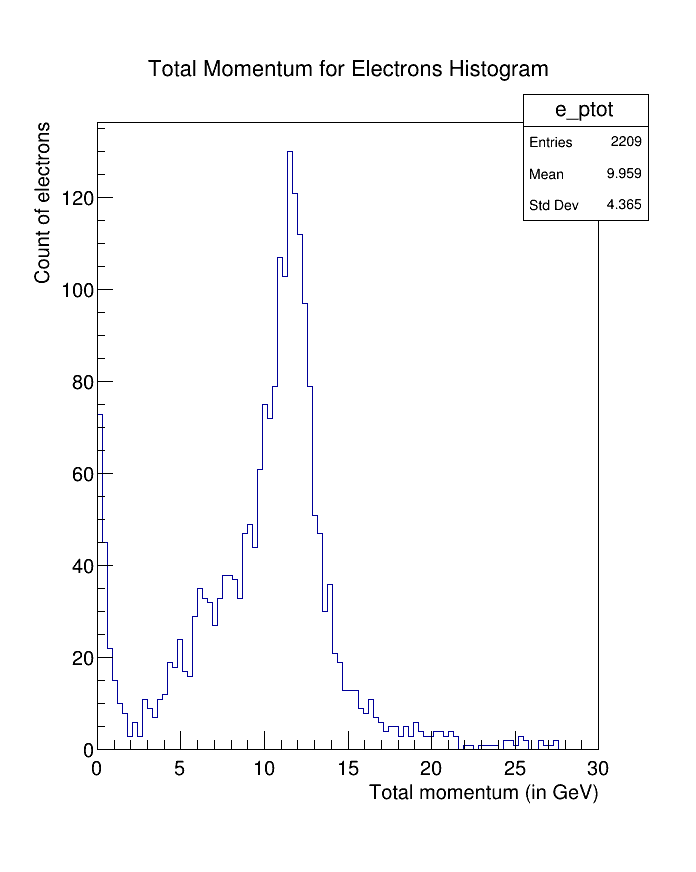

In [9]:
c_e_ptot = TCanvas('c_e_ptot', 'The canvas for total momentum', 200, 10, 700, 900)
pad_e_ptot = TPad('pad_e_ptot', 'The pad for p_total', 0.05, 0.05, 0.95, 0.95)

pad_e_ptot.Draw()
pad_e_ptot.cd()

e_ptot_hist.GetXaxis().SetTitle('Total momentum (in GeV)')
e_ptot_hist.GetYaxis().SetTitle('Count of electrons')
e_ptot_hist.Draw()

c_e_ptot.Update()
c_e_ptot.Draw()

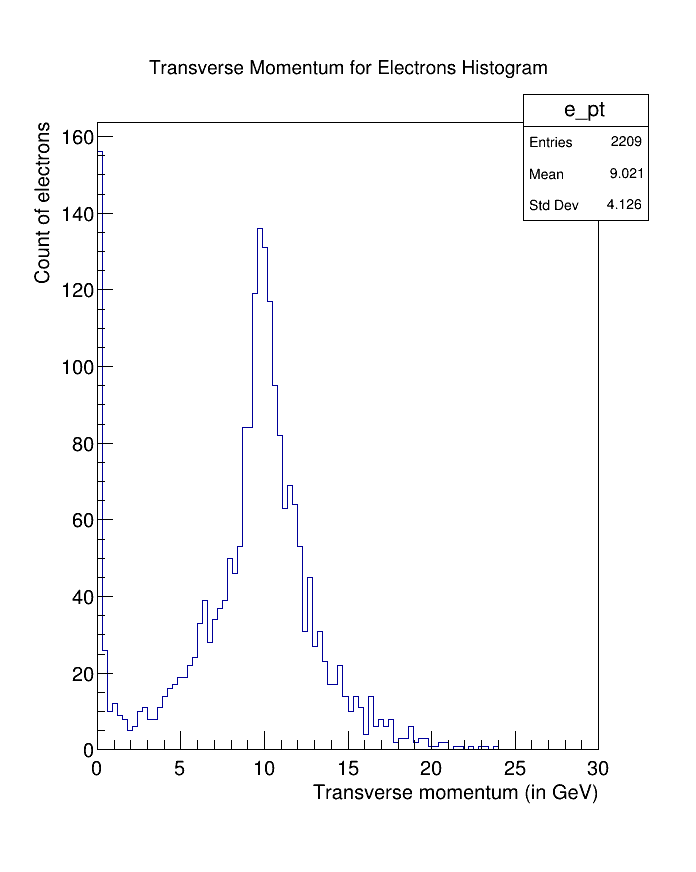

In [10]:
c_e_pt = TCanvas('c_e_pt', 'The canvas for transverse momentum', 200, 10, 700, 900)
pad_e_pt = TPad('pad_e_pt', 'The pad for p_t', 0.05, 0.05, 0.95, 0.95)

pad_e_pt.Draw()
pad_e_pt.cd()

e_pt_hist.GetXaxis().SetTitle('Transverse momentum (in GeV)')
e_pt_hist.GetYaxis().SetTitle('Count of electrons')
e_pt_hist.Draw()

c_e_pt.Update()
c_e_pt.Draw()

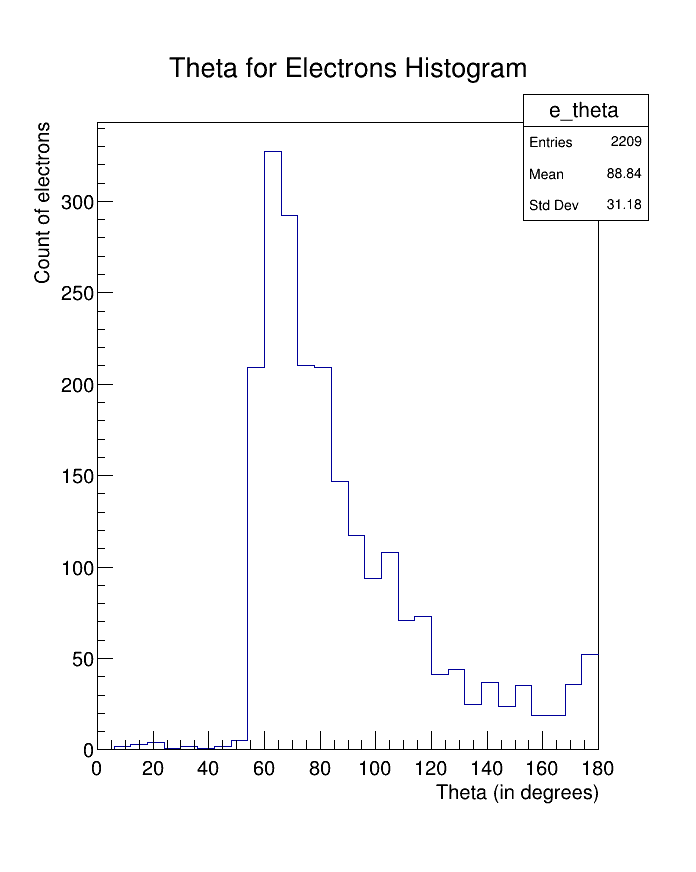

In [11]:
c_e_theta = TCanvas('c_e_theta', 'The canvas with the theta histogram', 200, 10, 700, 900)
pad_e_theta = TPad('pad_e_theta', 'The pad with theta', 0.05, 0.05, 0.95, 0.95)

pad_e_theta.Draw()
pad_e_theta.cd()

e_theta_hist.GetXaxis().SetTitle('Theta (in degrees)')
e_theta_hist.GetYaxis().SetTitle('Count of electrons')
e_theta_hist.Draw()

c_e_theta.Update()
c_e_theta.Draw()

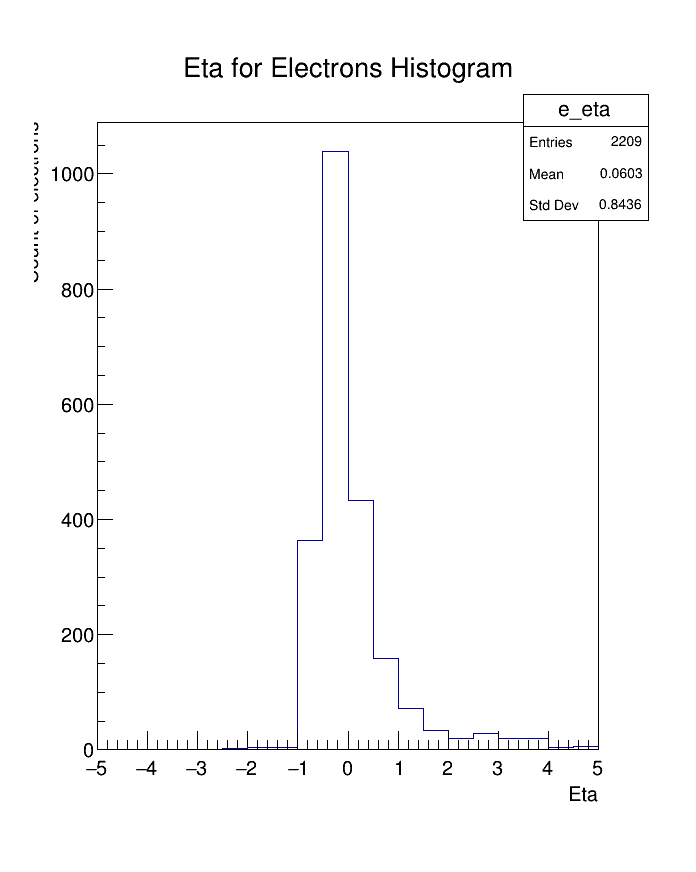

In [12]:
c_e_eta = TCanvas('c_e_eta', 'The canvas with the eta histogram', 200, 10, 700, 900)
pad_e_eta = TPad('pad_e_eta', 'The pad with eta', 0.05, 0.05, 0.95, 0.95)

pad_e_eta.Draw()
pad_e_eta.cd()

e_eta_hist.GetXaxis().SetTitle('Eta')
e_eta_hist.GetYaxis().SetTitle('Count of electrons')
e_eta_hist.Draw()

c_e_eta.Update()
c_e_eta.Draw()

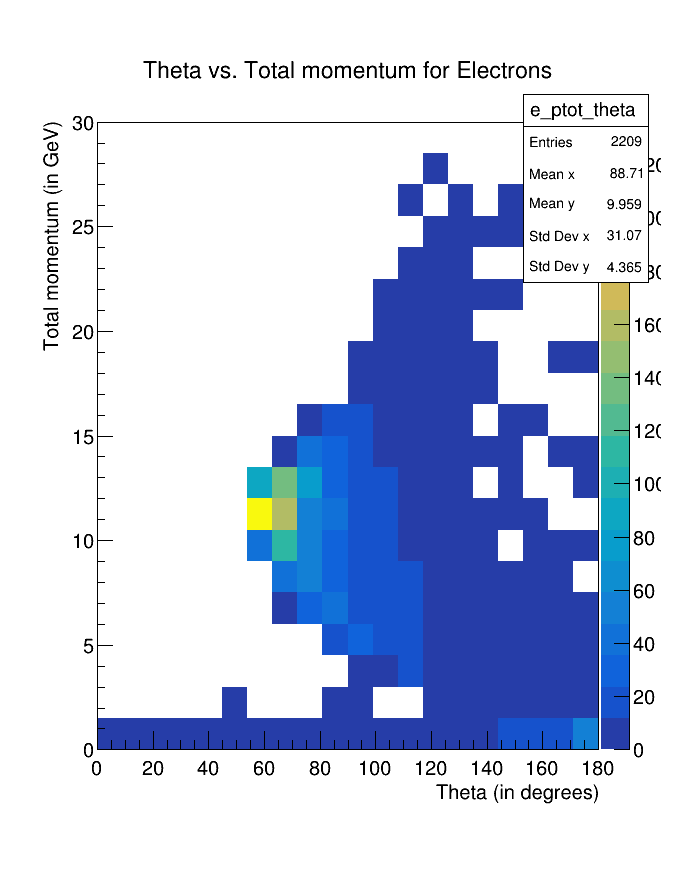

In [13]:
# Make title and axes
# Plot eta on x and p_total on y
# Add plot for eta vs. p_t

c_e_ptot_theta = TCanvas('c_e_ptot_theta', 'The canvas with total momentum vs theta', 200, 10, 700, 900)
pad_e_ptot_theta = TPad('pad_e_ptot_theta', 'The pad with total momentum vs theta', 0.05, 0.05, 0.95, 0.95)

pad_e_ptot_theta.Draw()
pad_e_ptot_theta.cd()

e_ptot_theta.GetXaxis().SetTitle('Theta (in degrees)')
e_ptot_theta.GetYaxis().SetTitle('Total momentum (in GeV)')
e_ptot_theta.Draw('colz')

c_e_ptot_theta.Update()
c_e_ptot_theta.Draw()

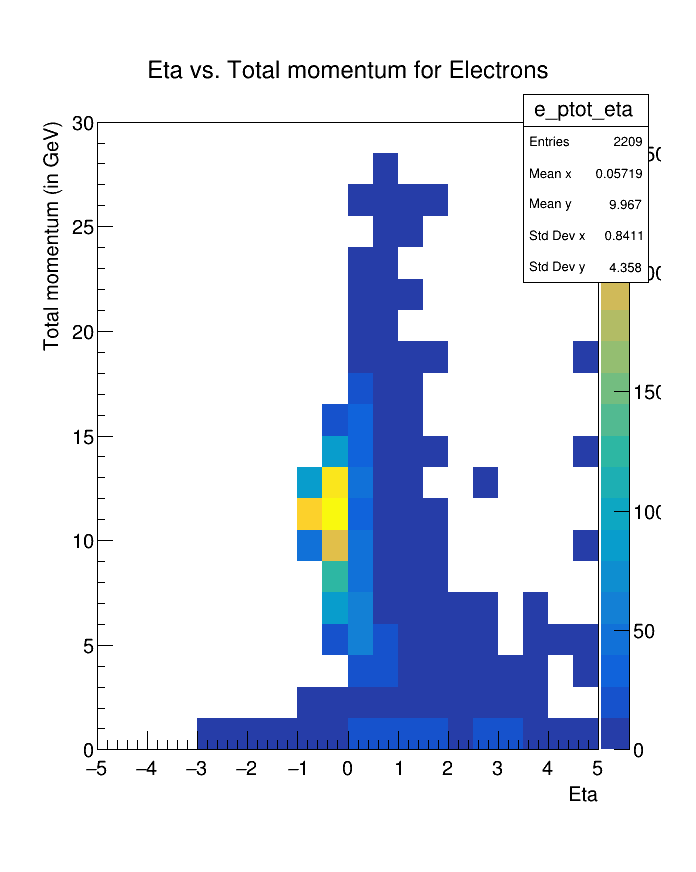

In [14]:
c_e_ptot_eta = TCanvas('c_e_ptot_eta', 'The canvas with total momentum vs eta', 200, 10, 700, 900)
pad_e_ptot_eta = TPad('pad_e_ptot_eta', 'The pad with total momentum vs eta', 0.05, 0.05, 0.95, 0.95)

pad_e_ptot_eta.Draw()
pad_e_ptot_eta.cd()

e_ptot_eta.GetXaxis().SetTitle('Eta')
e_ptot_eta.GetYaxis().SetTitle('Total momentum (in GeV)')
e_ptot_eta.Draw('colz')

c_e_ptot_eta.Update()
c_e_ptot_eta.Draw()

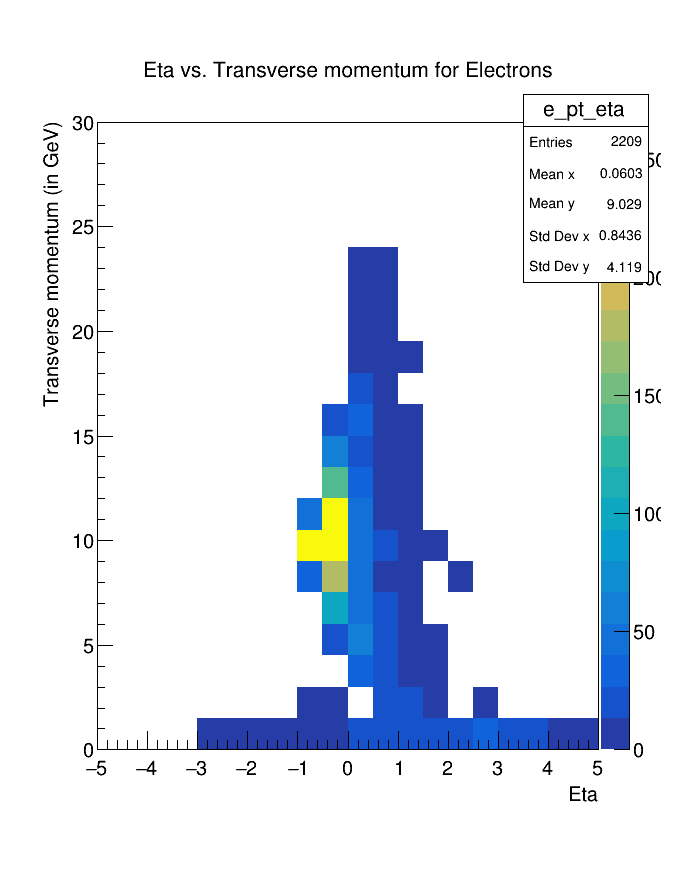

In [15]:
c_e_pt_eta = TCanvas('c_e_pt_eta', 'The canvas with transverse momentum vs eta', 200, 10, 700, 900)
pad_e_pt_eta = TPad('pad_e_pt_eta', 'The pad with transverse momentum vs eta', 0.05, 0.05, 0.95, 0.95)

pad_e_pt_eta.Draw()
pad_e_pt_eta.cd()

e_pt_eta.GetXaxis().SetTitle('Eta')
e_pt_eta.GetYaxis().SetTitle('Transverse momentum (in GeV)')
e_pt_eta.Draw('colz')

c_e_pt_eta.Update()
c_e_pt_eta.Draw()

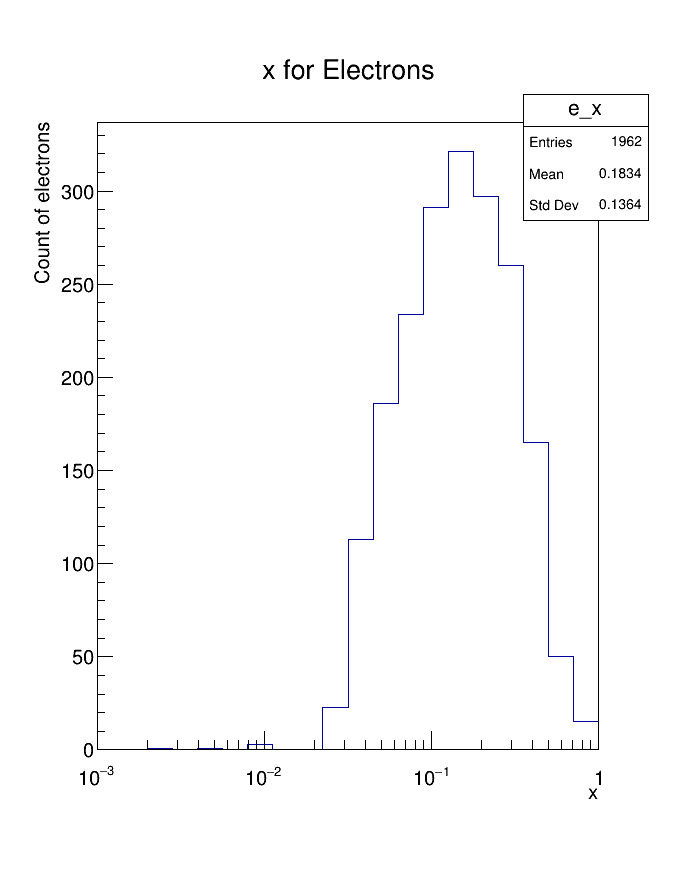

In [16]:
c_e_x = TCanvas('c_e_x', 'The canvas with x histogram', 200, 10, 700, 900)
pad_e_x = TPad('pad_e_x', 'The pad with x histogram', 0.05, 0.05, 0.95, 0.95)

pad_e_x.Draw()
pad_e_x.cd()
pad_e_x.SetLogx()

e_x_hist.GetXaxis().SetTitle('x')
e_x_hist.GetYaxis().SetTitle('Count of electrons')
e_x_hist.Draw()

c_e_x.Update()
c_e_x.Draw()

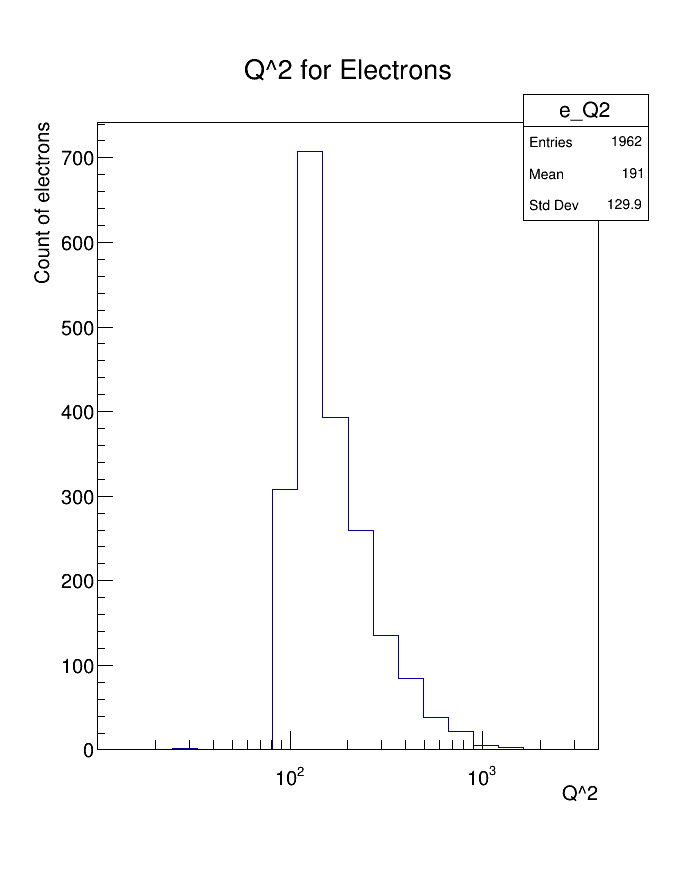

In [17]:
c_e_Q2 = TCanvas('c_e_Q2', 'The canvas with Q^2 histogram', 200, 10, 700, 900)
pad_e_Q2 = TPad('pad_e_Q2', 'The pad with Q^2 histogram', 0.05, 0.05, 0.95, 0.95)

pad_e_Q2.Draw()
pad_e_Q2.cd()
pad_e_Q2.SetLogx()

e_Q2_hist.GetXaxis().SetTitle('Q^2')
e_Q2_hist.GetYaxis().SetTitle('Count of electrons')
e_Q2_hist.Draw()

c_e_Q2.Update()
c_e_Q2.Draw()

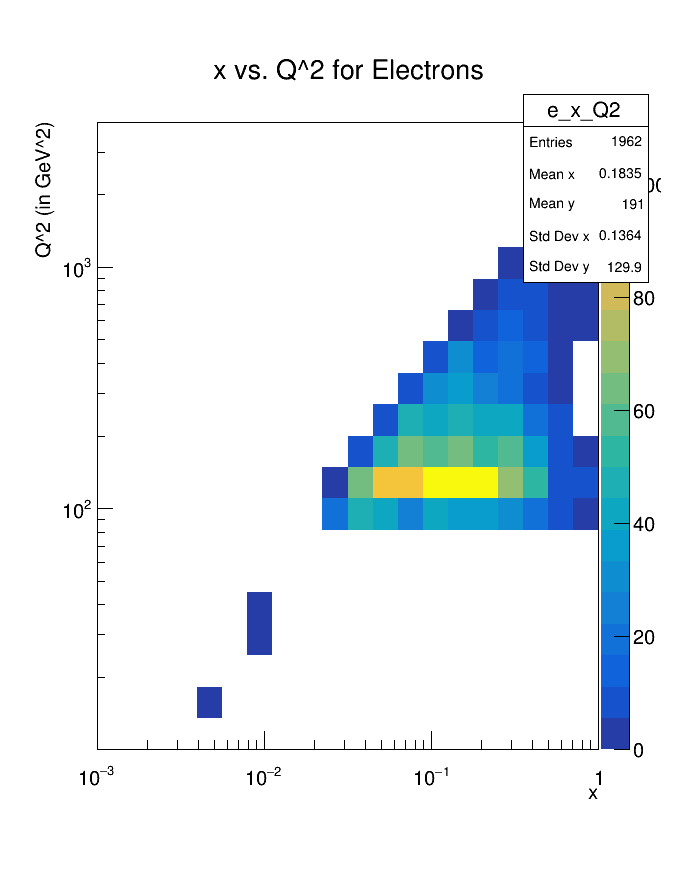

In [18]:
c_e_x_Q2 = TCanvas('c_e_x_Q2', 'The canvas with x vs Q^2', 200, 10, 700, 900)
pad_e_x_Q2 = TPad('pad_e_x_Q2', 'The pad with x vs Q^2', 0.05, 0.05, 0.95, 0.95)

pad_e_x_Q2.Draw()
pad_e_x_Q2.cd()
pad_e_x_Q2.SetLogx()
pad_e_x_Q2.SetLogy()

e_x_Q2.GetXaxis().SetTitle('x')
e_x_Q2.GetYaxis().SetTitle('Q^2 (in GeV^2)')
e_x_Q2.Draw('colz')

c_e_x_Q2.Update()
c_e_x_Q2.Draw()

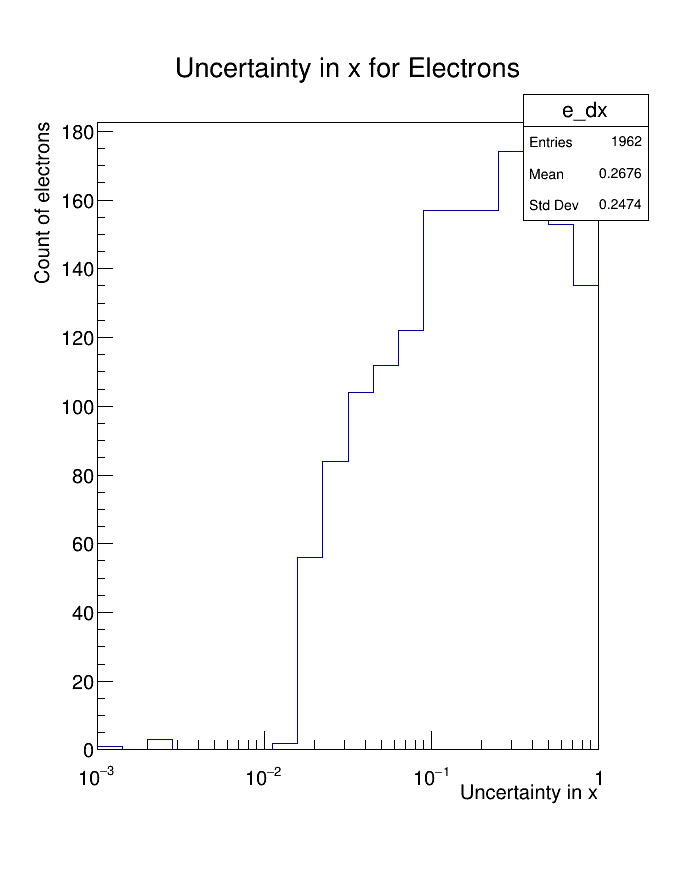

In [19]:
c_e_dx = TCanvas('c_e_dx', 'The canvas with dx histogram', 200, 10, 700, 900)
pad_e_dx = TPad('pad_e_dx', 'The pad with dx histogram', 0.05, 0.05, 0.95, 0.95)

pad_e_dx.Draw()
pad_e_dx.cd()
pad_e_dx.SetLogx()

e_dx_hist.GetXaxis().SetTitle('Uncertainty in x')
e_dx_hist.GetYaxis().SetTitle('Count of electrons')
e_dx_hist.Draw()

c_e_dx.Update()
c_e_dx.Draw()

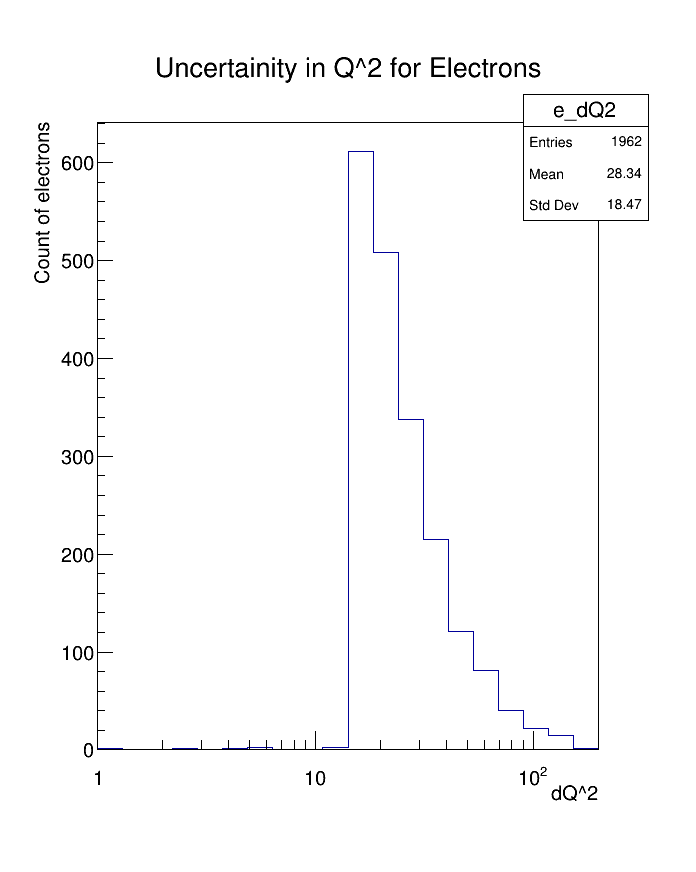

In [20]:
c_e_dQ2 = TCanvas('c_e_dQ2', 'The canvas with dQ^2 histogram', 200, 10, 700, 900)
pad_e_dQ2 = TPad('pad_e_dQ2', 'The pad with dQ^2 histogram', 0.05, 0.05, 0.95, 0.95)

pad_e_dQ2.Draw()
pad_e_dQ2.cd()
pad_e_dQ2.SetLogx()

e_dQ2_hist.GetXaxis().SetTitle('dQ^2')
e_dQ2_hist.GetYaxis().SetTitle('Count of electrons')
e_dQ2_hist.Draw()

c_e_dQ2.Update()
c_e_dQ2.Draw()

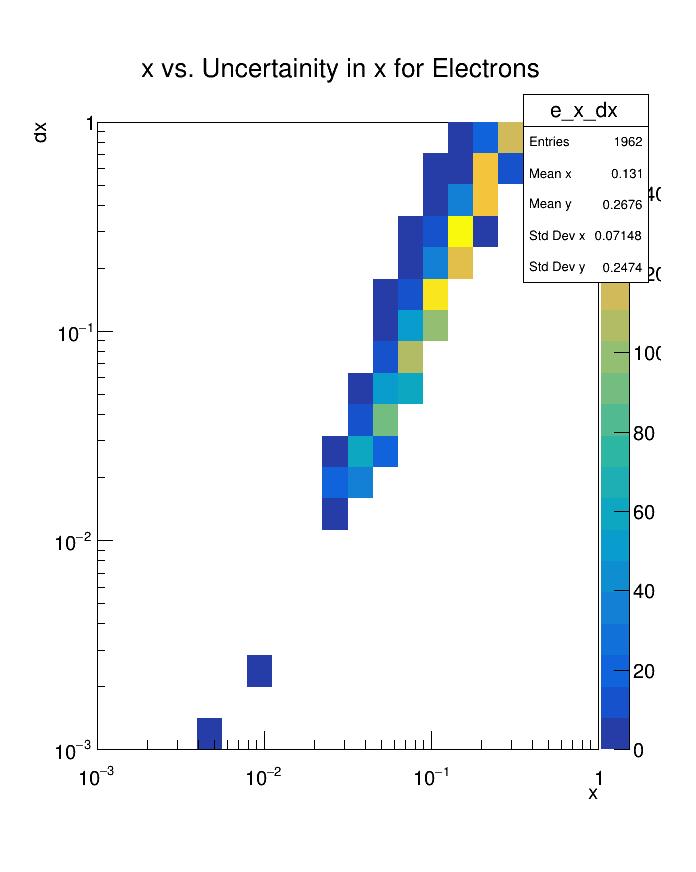

In [21]:
c_e_x_dx = TCanvas('c_e_x_dx', 'The canvas with x vs dx', 200, 10, 700, 900)
pad_e_x_dx = TPad('pad_e_x_dx', 'The pad with x vs dx', 0.05, 0.05, 0.95, 0.95)

pad_e_x_dx.Draw()
pad_e_x_dx.cd()
pad_e_x_dx.SetLogx()
pad_e_x_dx.SetLogy()

e_x_dx.GetXaxis().SetTitle('x')
e_x_dx.GetYaxis().SetTitle('dx')
e_x_dx.Draw('colz')

c_e_x_dx.Update()
c_e_x_dx.Draw()

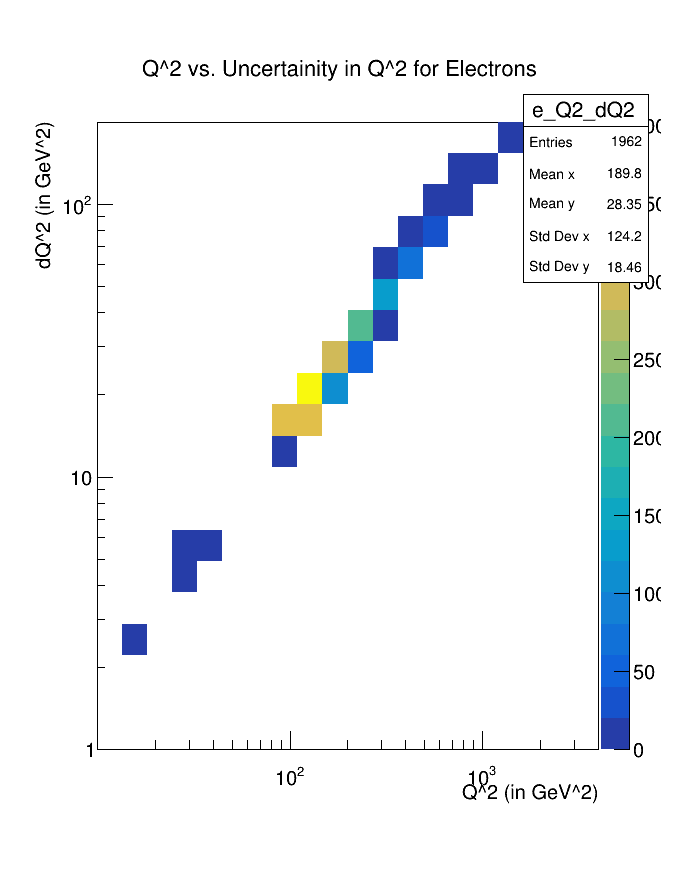

In [22]:
c_e_Q2_dQ2 = TCanvas('c_e_Q2_dQ2', 'The canvas with Q^2 vs dQ^2', 200, 10, 700, 900)
pad_e_Q2_dQ2 = TPad('pad_e_Q2_dQ2', 'The pad with Q^2 vs dQ^2', 0.05, 0.05, 0.95, 0.95)

pad_e_Q2_dQ2.Draw()
pad_e_Q2_dQ2.cd()
pad_e_Q2_dQ2.SetLogx()
pad_e_Q2_dQ2.SetLogy()

e_Q2_dQ2.GetXaxis().SetTitle('Q^2 (in GeV^2)')
e_Q2_dQ2.GetYaxis().SetTitle('dQ^2 (in GeV^2)')
e_Q2_dQ2.Draw('colz')

c_e_Q2_dQ2.Update()
c_e_Q2_dQ2.Draw()

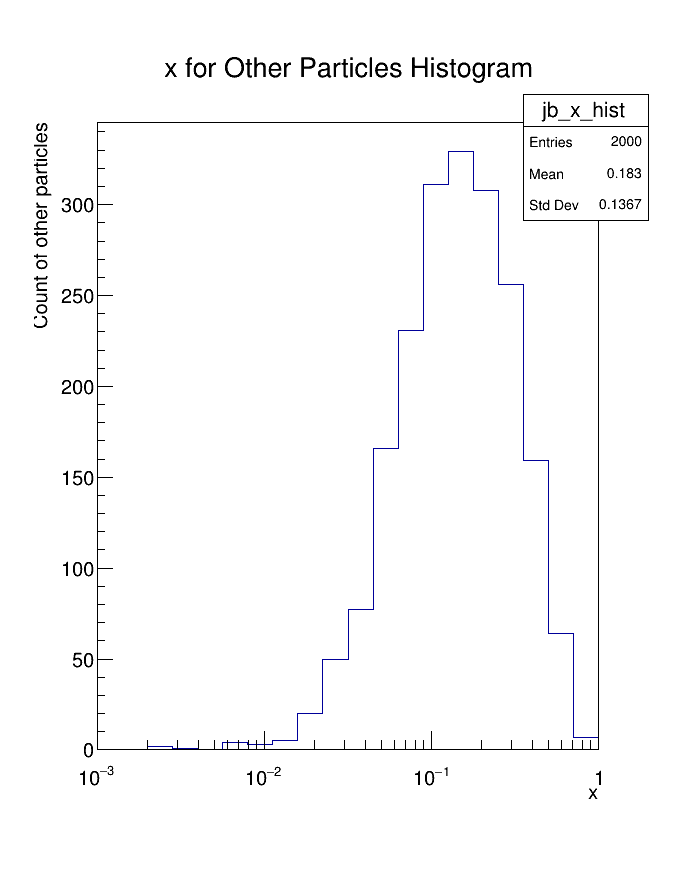

In [23]:
c_jb_x = TCanvas('c_jb_x', 'The canvas with x histogram', 200, 10, 700, 900)
pad_jb_x = TPad('pad_jb_x', 'The pad with x histogram', 0.05, 0.05, 0.95, 0.95)

pad_jb_x.Draw()
pad_jb_x.cd()
pad_jb_x.SetLogx()

# Make it a log scale
# Make 10 (check to see which number is best) horizontal bins
#   on a log scale from 10^-3 to 1
jb_x_hist.GetXaxis().SetTitle('x')
jb_x_hist.GetYaxis().SetTitle('Count of other particles')
jb_x_hist.Draw()

c_jb_x.Update()
c_jb_x.Draw()

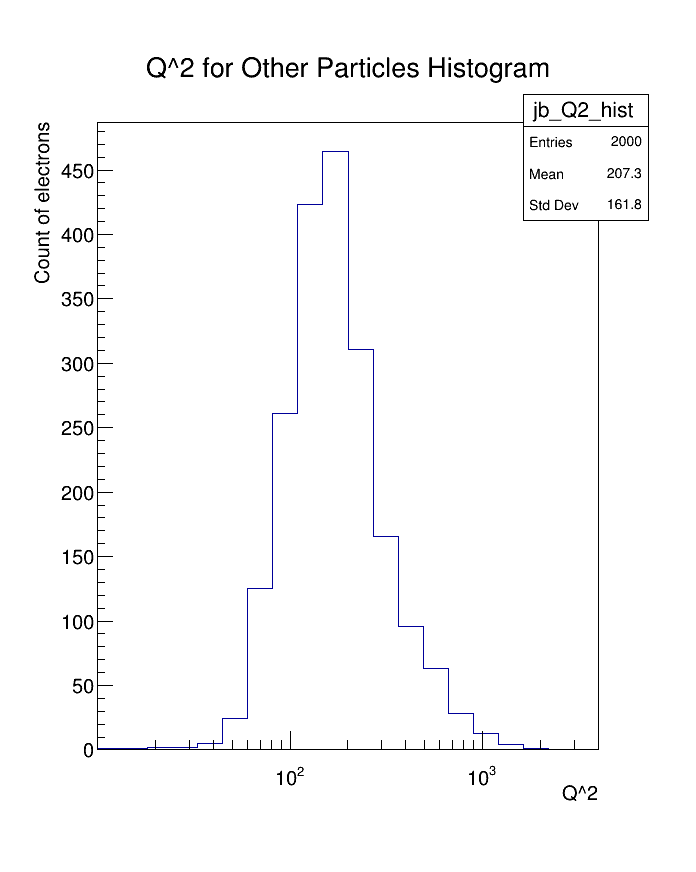

In [24]:
c_jb_Q2 = TCanvas('c_jb_Q2', 'The canvas with Q^2 histogram', 200, 10, 700, 900)
pad_jb_Q2 = TPad('pad_jb_Q2', 'The pad with Q^2 histogram', 0.05, 0.05, 0.95, 0.95)

pad_jb_Q2.Draw()
pad_jb_Q2.cd()
pad_jb_Q2.SetLogx()

# Resolution for Q^2 is very bad
# Make it a log scale
jb_Q2_hist.GetXaxis().SetTitle('Q^2')
jb_Q2_hist.GetYaxis().SetTitle('Count of electrons')
jb_Q2_hist.Draw()

c_jb_Q2.Update()
c_jb_Q2.Draw()

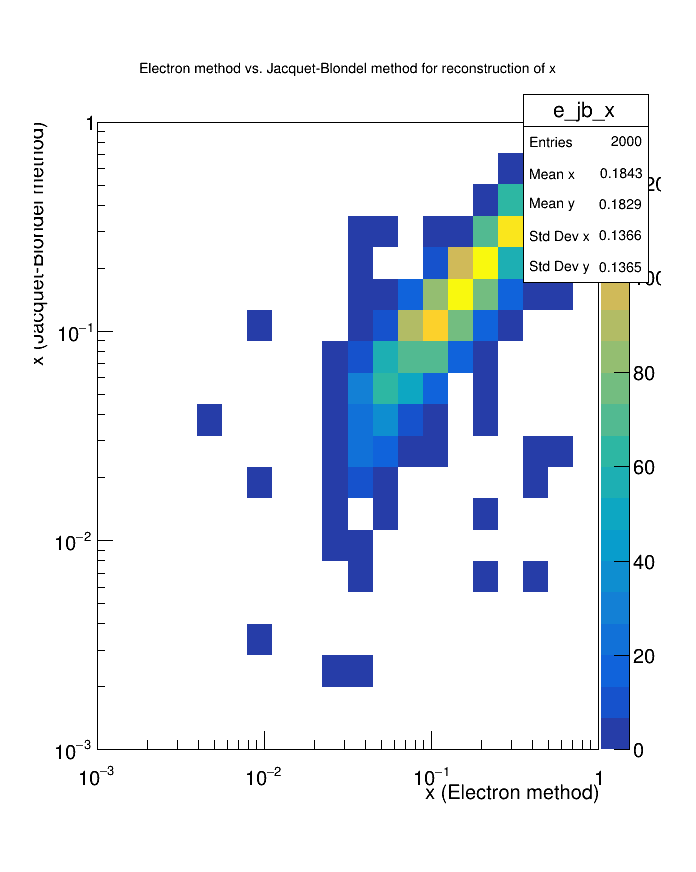

In [25]:
c_e_jb_x = TCanvas('c_e_jb_x', 'The canvas with e vs. JB x', 200, 10, 700, 900)
pad_e_jb_x = TPad('pad_e_jb_x', 'The pad with e vs. JB x', 0.05, 0.05, 0.95, 0.95)

pad_e_jb_x.Draw()
pad_e_jb_x.cd()
pad_e_jb_x.SetLogx()
pad_e_jb_x.SetLogy()

e_jb_x.GetXaxis().SetTitle('x (Electron method)')
e_jb_x.GetYaxis().SetTitle('x (Jacquet-Blondel method)')
e_jb_x.Draw('colz')

c_e_jb_x.Update()
c_e_jb_x.Draw()

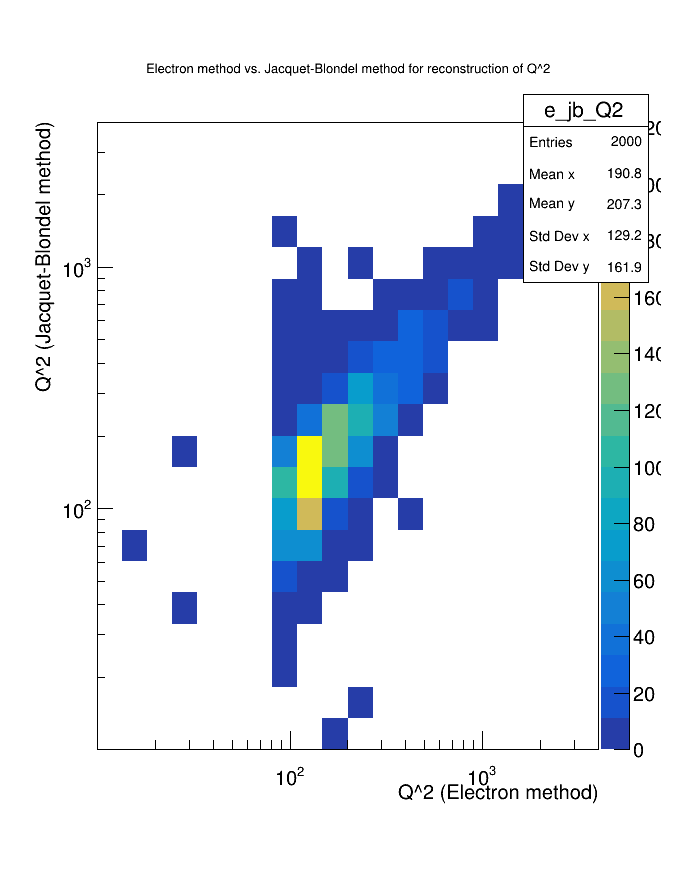

In [26]:
# Plot difference between electron and JB Q^2

c_e_jb_Q2 = TCanvas('c_e_jb_Q2', 'The canvas with e vs. JB Q^2', 200, 10, 700, 900)
pad_e_jb_Q2 = TPad('pad_e_jb_Q2', 'The pad with e vs. JB Q^2', 0.05, 0.05, 0.95, 0.95)

pad_e_jb_Q2.Draw()
pad_e_jb_Q2.cd()
pad_e_jb_Q2.SetLogx()
pad_e_jb_Q2.SetLogy()

e_jb_Q2.GetXaxis().SetTitle('Q^2 (Electron method)')
e_jb_Q2.GetYaxis().SetTitle('Q^2 (Jacquet-Blondel method)')
e_jb_Q2.Draw('colz')

c_e_jb_Q2.Update()
c_e_jb_Q2.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c_Q2_pf


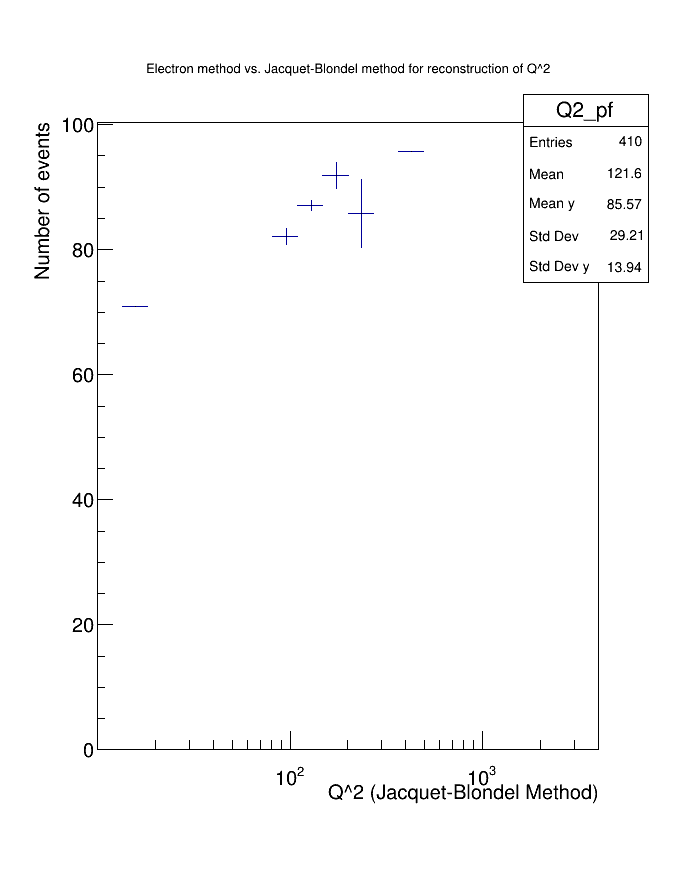

In [31]:
c_Q2_pf = TCanvas('c_Q2_pf', 'The canvas with e vs. JB Q^2 profile', 200, 10, 700, 900)
pad_Q2_pf = TPad('pad_Q2_pf', 'The pad with e vs. JB Q^2 profile', 0.05, 0.05, 0.95, 0.95)

pad_Q2_pf.Draw()
pad_Q2_pf.cd()
pad_Q2_pf.SetLogx()

Q2_pf = e_jb_Q2.ProfileX('Q2_pf', 6, 8)
Q2_pf.GetXaxis().SetTitle('Q^2 (Jacquet-Blondel Method)')
Q2_pf.GetYaxis().SetTitle('Number of events')
Q2_pf.Draw()

c_Q2_pf.Update()
c_Q2_pf.Draw()

In [27]:
# Calculate x and Q^2 using charged particles (not electrons)
# Plot these values
# Only include -4 < eta < 4
# Compare with electron method


# In new notebook
# Use machine learning (with electron method values as "true" values) to find Jacquet-Blondel method

In another notebook, we look at using machine learning to determine the values of $x$ and $Q^2$ from the values obtained from the jet. To do this, we'll take the values obtained from the electron method as training values.